### Video Classification using LSTM + Pooling Layer

In [57]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp 

import torch 
import torch.nn as nn
import torch.nn.functional as F

In [58]:
mp_holist = mp.solutions.holistic 
mp_draw = mp.solutions.drawing_utils

In [59]:
def mediapipe_detection(img, model):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img.flags.writeable = False                 
    result = model.process(img)                 # Make prediction
    img.flags.writeable = True                   
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) 
    return img, result

In [60]:
def draw_landmarks(img, result):
    mp_draw.draw_landmarks(img, result.face_landmarks, mp_holist.FACEMESH_CONTOURS) # Draw face connections
    mp_draw.draw_landmarks(img, result.pose_landmarks, mp_holist.POSE_CONNECTIONS) # Draw pose connections
    mp_draw.draw_landmarks(img, result.left_hand_landmarks, mp_holist.HAND_CONNECTIONS) # Draw left hand connections
    mp_draw.draw_landmarks(img, result.right_hand_landmarks, mp_holist.HAND_CONNECTIONS) # Draw right hand connections

In [61]:
def draw_styled_landmarks(img, result):
    mp_draw.draw_landmarks(img, result.face_landmarks, mp_holist.FACEMESH_CONTOURS, 
                             mp_draw.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), # color the joint 
                             mp_draw.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1) #color the connection
                             ) 
    # mp_draw.draw_landmarks(img, result.face_landmarks, mp_holist.FACEMESH_CONTOURS, 
    #                          mp_draw.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), # color the joint 
    #                          mp_draw.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1) #color the connection
    #                          ) 
    
    mp_draw.draw_landmarks(img, result.pose_landmarks, mp_holist.POSE_CONNECTIONS,
                             mp_draw.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_draw.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    mp_draw.draw_landmarks(img, result.left_hand_landmarks, mp_holist.HAND_CONNECTIONS, 
                             mp_draw.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_draw.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    mp_draw.draw_landmarks(img, result.right_hand_landmarks, mp_holist.HAND_CONNECTIONS, 
                             mp_draw.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_draw.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [62]:
mp_holist.POSE_CONNECTIONS

frozenset({(0, 1),
           (0, 4),
           (1, 2),
           (2, 3),
           (3, 7),
           (4, 5),
           (5, 6),
           (6, 8),
           (9, 10),
           (11, 12),
           (11, 13),
           (11, 23),
           (12, 14),
           (12, 24),
           (13, 15),
           (14, 16),
           (15, 17),
           (15, 19),
           (15, 21),
           (16, 18),
           (16, 20),
           (16, 22),
           (17, 19),
           (18, 20),
           (23, 24),
           (23, 25),
           (24, 26),
           (25, 27),
           (26, 28),
           (27, 29),
           (27, 31),
           (28, 30),
           (28, 32),
           (29, 31),
           (30, 32)})

In [63]:
def extract_keypoints(results):
    pose=np.array([[res.x,res.y,res.z,res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    left_hnd=np.array([[res.x,res.y,res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    right_hnd=np.array([[res.x,res.y,res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    face=np.array([[res.x,res.y,res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    return np.concatenate([pose,left_hnd,right_hnd,face])
# concatenating for the model to detect the sign language

In [64]:
import os 
video_dir = "C:/Users/araya/Desktop/keypoints/video_extract"
video_list = []
video_list = os.listdir(video_dir)

len(video_list)

40

In [65]:
video_list

['กฎกระทรวง.mp4',
 'กฎหมายรัฐธรรมนูญ.mp4',
 'กรมอนามัย.mp4',
 'กรรม.mp4',
 'กรรมสิทธิ์.mp4',
 'กระโดด.mp4',
 'กล้วยบวชชี.mp4',
 'กล้วยเชื่อม.mp4',
 'กังวล.mp4',
 'กีฬา.mp4',
 'น้อง.mp4',
 'เขิน.mp4',
 'เขื่อนดิน.mp4',
 'เขื่อนสิริกิติ์.mp4',
 'เข้าใจผิด.mp4',
 'เคย.mp4',
 'เครียด.mp4',
 'เครื่องปั่นดิน.mp4',
 'เครื่องหมายการค้า.mp4',
 'เจอ.mp4',
 'เจ้าหนี้.mp4',
 'เช่าซื้อ.mp4',
 'เช่าทรัพย์.mp4',
 'เซอร์เบีย.mp4',
 'เซเนกัล.mp4',
 'เซ็ง.mp4',
 'เดิน.mp4',
 'เดิมพัน.mp4',
 'เพลีย.mp4',
 'เมื่อย.mp4',
 'เม็กซิโก.mp4',
 'เฮโรอีน.mp4',
 'แกมเบีย.mp4',
 'แซมเบีย.mp4',
 'โกหก.mp4',
 'โจทก์.mp4',
 'โชจู.mp4',
 'ใกล้.mp4',
 'ไดโนเสาร์.mp4',
 'ไอซ์.mp4']

In [66]:
# Path for exported data, numpy arrays
Model_Data=os.path.join('Data for different actions')

actions = np.array(video_list)

no_of_seqs = 1

# 30 frames in length
seq_length = 160

In [67]:
actions

array(['กฎกระทรวง.mp4', 'กฎหมายรัฐธรรมนูญ.mp4', 'กรมอนามัย.mp4',
       'กรรม.mp4', 'กรรมสิทธิ์.mp4', 'กระโดด.mp4', 'กล้วยบวชชี.mp4',
       'กล้วยเชื่อม.mp4', 'กังวล.mp4', 'กีฬา.mp4', 'น้อง.mp4', 'เขิน.mp4',
       'เขื่อนดิน.mp4', 'เขื่อนสิริกิติ์.mp4', 'เข้าใจผิด.mp4', 'เคย.mp4',
       'เครียด.mp4', 'เครื่องปั่นดิน.mp4', 'เครื่องหมายการค้า.mp4',
       'เจอ.mp4', 'เจ้าหนี้.mp4', 'เช่าซื้อ.mp4', 'เช่าทรัพย์.mp4',
       'เซอร์เบีย.mp4', 'เซเนกัล.mp4', 'เซ็ง.mp4', 'เดิน.mp4',
       'เดิมพัน.mp4', 'เพลีย.mp4', 'เมื่อย.mp4', 'เม็กซิโก.mp4',
       'เฮโรอีน.mp4', 'แกมเบีย.mp4', 'แซมเบีย.mp4', 'โกหก.mp4',
       'โจทก์.mp4', 'โชจู.mp4', 'ใกล้.mp4', 'ไดโนเสาร์.mp4', 'ไอซ์.mp4'],
      dtype='<U21')

Collecting keypoint values for Training nd Testing

In [68]:
# Define the directory where your videos are stored
directory = "C:/Users/araya/Desktop/keypoints/video_extract"

In [69]:
directory

'C:/Users/araya/Desktop/keypoints/video_extract'

In [70]:
for filename in actions:
    print(directory + '/' + filename)

C:/Users/araya/Desktop/keypoints/video_extract/กฎกระทรวง.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กฎหมายรัฐธรรมนูญ.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กรมอนามัย.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กรรม.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กรรมสิทธิ์.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กระโดด.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กล้วยบวชชี.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กล้วยเชื่อม.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กังวล.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กีฬา.mp4
C:/Users/araya/Desktop/keypoints/video_extract/น้อง.mp4
C:/Users/araya/Desktop/keypoints/video_extract/เขิน.mp4
C:/Users/araya/Desktop/keypoints/video_extract/เขื่อนดิน.mp4
C:/Users/araya/Desktop/keypoints/video_extract/เขื่อนสิริกิติ์.mp4
C:/Users/araya/Desktop/keypoints/video_extract/เข้าใจผิด.mp4
C:/Users/araya/Desktop/keypoints/video_extract/เคย.mp4
C:/Users/araya/Desktop/keypoints/video_e

In [71]:
file_paths = []
for action in actions:
    video_path = os.path.join('Data for different actions/', action)
    # print(video_path)
    # print(action)
    file_paths.append(video_path + '/' + action.split(".")[0] + ".npy")
print(file_paths)

['Data for different actions/กฎกระทรวง.mp4/กฎกระทรวง.npy', 'Data for different actions/กฎหมายรัฐธรรมนูญ.mp4/กฎหมายรัฐธรรมนูญ.npy', 'Data for different actions/กรมอนามัย.mp4/กรมอนามัย.npy', 'Data for different actions/กรรม.mp4/กรรม.npy', 'Data for different actions/กรรมสิทธิ์.mp4/กรรมสิทธิ์.npy', 'Data for different actions/กระโดด.mp4/กระโดด.npy', 'Data for different actions/กล้วยบวชชี.mp4/กล้วยบวชชี.npy', 'Data for different actions/กล้วยเชื่อม.mp4/กล้วยเชื่อม.npy', 'Data for different actions/กังวล.mp4/กังวล.npy', 'Data for different actions/กีฬา.mp4/กีฬา.npy', 'Data for different actions/น้อง.mp4/น้อง.npy', 'Data for different actions/เขิน.mp4/เขิน.npy', 'Data for different actions/เขื่อนดิน.mp4/เขื่อนดิน.npy', 'Data for different actions/เขื่อนสิริกิติ์.mp4/เขื่อนสิริกิติ์.npy', 'Data for different actions/เข้าใจผิด.mp4/เข้าใจผิด.npy', 'Data for different actions/เคย.mp4/เคย.npy', 'Data for different actions/เครียด.mp4/เครียด.npy', 'Data for different actions/เครื่องปั่นดิน.mp4/เครื

In [72]:
def load_keypoint_sequences(file_paths):
    keypoint_sequences = []
    for file_path in file_paths:
        keypoints = np.load(file_path)
        keypoint_sequences.append(torch.tensor(keypoints, dtype=torch.float32))
    return keypoint_sequences

In [73]:
# Load the sequences
import torch
sequences = load_keypoint_sequences(file_paths)
sequences

[tensor([[ 0.5013,  0.2452, -1.2167,  ...,  0.5663,  0.2188,  0.0098],
         [ 0.4997,  0.2482, -1.4690,  ...,  0.5652,  0.2181,  0.0106],
         [ 0.4984,  0.2500, -1.4853,  ...,  0.5654,  0.2185,  0.0112],
         ...,
         [ 0.4861,  0.2513, -1.3416,  ...,  0.5572,  0.2177,  0.0091],
         [ 0.4873,  0.2514, -1.3574,  ...,  0.5575,  0.2172,  0.0097],
         [ 0.4883,  0.2516, -1.3579,  ...,  0.5577,  0.2170,  0.0101]]),
 tensor([[ 0.4922,  0.2382, -1.2850,  ...,  0.5578,  0.2124,  0.0094],
         [ 0.4920,  0.2405, -1.4288,  ...,  0.5571,  0.2116,  0.0099],
         [ 0.4920,  0.2409, -1.4093,  ...,  0.5567,  0.2122,  0.0098],
         ...,
         [ 0.4814,  0.2260, -1.3318,  ...,  0.5503,  0.1923,  0.0123],
         [ 0.4815,  0.2257, -1.3351,  ...,  0.5503,  0.1921,  0.0122],
         [ 0.4815,  0.2255, -1.3497,  ...,  0.5501,  0.1919,  0.0124]]),
 tensor([[ 0.5049,  0.2371, -1.2115,  ...,  0.5643,  0.2082,  0.0088],
         [ 0.5045,  0.2381, -1.1896,  ...,  0

In [74]:
# Pad the sequences to the same length
from torch.nn.utils.rnn import pad_sequence
padded_sequences = pad_sequence(sequences, batch_first=True)
pad_sequence
print(padded_sequences.shape) # (batch_size, max_sequence_length, num_keypoints)

torch.Size([40, 160, 1662])


In [75]:
labels = [action.split(".")[0] for action in actions]
labels

['กฎกระทรวง',
 'กฎหมายรัฐธรรมนูญ',
 'กรมอนามัย',
 'กรรม',
 'กรรมสิทธิ์',
 'กระโดด',
 'กล้วยบวชชี',
 'กล้วยเชื่อม',
 'กังวล',
 'กีฬา',
 'น้อง',
 'เขิน',
 'เขื่อนดิน',
 'เขื่อนสิริกิติ์',
 'เข้าใจผิด',
 'เคย',
 'เครียด',
 'เครื่องปั่นดิน',
 'เครื่องหมายการค้า',
 'เจอ',
 'เจ้าหนี้',
 'เช่าซื้อ',
 'เช่าทรัพย์',
 'เซอร์เบีย',
 'เซเนกัล',
 'เซ็ง',
 'เดิน',
 'เดิมพัน',
 'เพลีย',
 'เมื่อย',
 'เม็กซิโก',
 'เฮโรอีน',
 'แกมเบีย',
 'แซมเบีย',
 'โกหก',
 'โจทก์',
 'โชจู',
 'ใกล้',
 'ไดโนเสาร์',
 'ไอซ์']

In [76]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

labels = le.fit_transform(labels)
labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39], dtype=int64)

In [77]:
# import pandas as pd
# y = pd.read_csv("script.csv")
# y

In [78]:
# y["label"] = y["label"].astype(int)
# labels = y.label
# labels

In [79]:
import torch
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

# Create a custom dataset
class KeypointDataset(Dataset):
    def __init__(self, file_paths, labels):
        self.file_paths = file_paths
        self.labels = labels
    
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        keypoints = np.load(self.file_paths[idx])
        label = self.labels[idx]
        return torch.tensor(keypoints, dtype=torch.float32), label

In [80]:
# Create the dataset
dataset = KeypointDataset(file_paths, labels)

In [81]:
print(dataset.file_paths)
print(dataset.labels)

['Data for different actions/กฎกระทรวง.mp4/กฎกระทรวง.npy', 'Data for different actions/กฎหมายรัฐธรรมนูญ.mp4/กฎหมายรัฐธรรมนูญ.npy', 'Data for different actions/กรมอนามัย.mp4/กรมอนามัย.npy', 'Data for different actions/กรรม.mp4/กรรม.npy', 'Data for different actions/กรรมสิทธิ์.mp4/กรรมสิทธิ์.npy', 'Data for different actions/กระโดด.mp4/กระโดด.npy', 'Data for different actions/กล้วยบวชชี.mp4/กล้วยบวชชี.npy', 'Data for different actions/กล้วยเชื่อม.mp4/กล้วยเชื่อม.npy', 'Data for different actions/กังวล.mp4/กังวล.npy', 'Data for different actions/กีฬา.mp4/กีฬา.npy', 'Data for different actions/น้อง.mp4/น้อง.npy', 'Data for different actions/เขิน.mp4/เขิน.npy', 'Data for different actions/เขื่อนดิน.mp4/เขื่อนดิน.npy', 'Data for different actions/เขื่อนสิริกิติ์.mp4/เขื่อนสิริกิติ์.npy', 'Data for different actions/เข้าใจผิด.mp4/เข้าใจผิด.npy', 'Data for different actions/เคย.mp4/เคย.npy', 'Data for different actions/เครียด.mp4/เครียด.npy', 'Data for different actions/เครื่องปั่นดิน.mp4/เครื

In [82]:
# Collate function for padding
def collate_fn(batch):
    sequences, labels = zip(*batch)
    padded_sequences = pad_sequence(sequences, batch_first=True)
    return padded_sequences, torch.tensor(labels)

In [83]:
# Create the DataLoader
batch_size = 4
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
data_loader

In [84]:
# Set device (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [85]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes,dropout):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.pool = nn.MaxPool2d(kernel_size=1, stride=1)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        # h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # ทำ pooling ก่อนเข้า LSTM epochs=300 ได้ accuracy = 40-50%
        x = self.pool(x)

        # Forward propagate the LSTM
        out, _ = self.lstm(self.dropout(x))

        # ทำ pooling หลัง LSTM epochs=300 ได้ accuracy = 30%
        # out = self.pool(out)
        
        # Use the last time step's output for classification
        out = out[:, -1, :]
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [86]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from sklearn.metrics import f1_score

# class LSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, num_classes,dropout):
#         super(LSTMModel, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.pool = nn.MaxPool2d(kernel_size=(2,1), stride=1)
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#         self.fc1 = nn.Linear(hidden_size, 256)
#         self.fc2 = nn.Linear(256, num_classes)
#         self.dropout = nn.Dropout(dropout)
    
#     def forward(self, x):
#         # h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
#         # c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
#         # ทำ pooling ก่อนเข้า LSTM epochs=300 ได้ accuracy = 40-50%
#         x = self.pool(x)

#         # Forward propagate the LSTM
#         out, _ = self.lstm(self.dropout(x))

#         # ทำ pooling หลัง LSTM epochs=300 ได้ accuracy = 30%
#         # out = self.pool(out)
        
#         # Use the last time step's output for classification
#         out = out[:, -1, :]
#         out = self.fc1(out)
#         out = self.fc2(out)
#         return out

In [87]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from sklearn.metrics import f1_score

# class Encoder(nn.Module):
#     def __init__(self, input_size, num_heads, dropout):
#         super().__init__()
#         self.multihead = nn.MultiheadAttention(embed_dim=input_size, num_heads=num_heads)
#         self.normalize_layer = nn.LayerNorm(normalized_shape=input_size, eps=1e-5)
#         self.fc1 = nn.Linear(input_size, input_size)
#         self.dropout = nn.Dropout(dropout)

#     def forward(self, x):
#         attn_output, attn_output_weights = self.multihead(x, x, x)

#         normalize_attn = self.normalize_layer(x+attn_output)

#         final_output = self.normalize_layer(self.fc1(normalize_attn)+normalize_attn)

#         return final_output



In [88]:
# Initialize the model, loss function, and optimizer
model = LSTMModel(input_size=1662, hidden_size=256, num_layers=2, num_classes=40, dropout=0.5).to(device)
# model = Encoder(input_size=1662, num_heads=6, dropout=0.5)

In [89]:
model.eval()

LSTMModel(
  (pool): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(1662, 256, num_layers=2, batch_first=True)
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=40, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [90]:
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [97]:
# Training loop
# References : https://saturncloud.io/blog/calculating-the-accuracy-of-pytorch-models-every-epoch/#:~:text=In%20order%20to%20calculate%20the,tensor%20along%20a%20specified%20dimension

from sklearn.metrics import f1_score, recall_score

num_epochs = 900
loss_logger = []
accuracy_logger = []
f1_logger = []
recall_logger = []

all_preds = []
all_labels = []
# n_epochs = []
for epoch in range(num_epochs):
    total_correct = 0
    total_samples = 0
    model.train()
    for i, (sequences, labels) in enumerate(data_loader):
        # Move data to the device
        # labels = labels.type(torch.LongTensor)   # casting to long
        sequences = sequences.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(sequences)
        _, predicted = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        # Store predictions and labels for calculating metrics
        all_preds.extend(predicted.cpu().numpy())  # Store predictions
        all_labels.extend(labels.cpu().numpy())    # Store true labels
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss_logger.append(loss.item())
    loss_logger.append(loss.item())
    accuracy = 100 * total_correct /total_samples

    # Calculate F1 score and recall
    f1 = f1_score(all_labels, all_preds, average='weighted')  # Weighted average for multi-class
    recall = recall_score(all_labels, all_preds, average='weighted')

    f1_logger.append(f1)
    recall_logger.append(recall)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f} , Accuracy : {accuracy:.2f}%, F1 Score: {f1:.2f}, Recall: {recall:.2f}')
    accuracy_logger.append(accuracy)
    # n_epochs.append(epoch)

Epoch [1/900], Loss: 3.7122 , Accuracy : 2.50%, F1 Score: 0.01, Recall: 0.03
Epoch [2/900], Loss: 3.7534 , Accuracy : 2.50%, F1 Score: 0.00, Recall: 0.03
Epoch [3/900], Loss: 4.3167 , Accuracy : 2.50%, F1 Score: 0.00, Recall: 0.03
Epoch [4/900], Loss: 3.5719 , Accuracy : 2.50%, F1 Score: 0.01, Recall: 0.03
Epoch [5/900], Loss: 3.7672 , Accuracy : 0.00%, F1 Score: 0.01, Recall: 0.02
Epoch [6/900], Loss: 3.9324 , Accuracy : 2.50%, F1 Score: 0.01, Recall: 0.02
Epoch [7/900], Loss: 3.9351 , Accuracy : 5.00%, F1 Score: 0.01, Recall: 0.03
Epoch [8/900], Loss: 3.3258 , Accuracy : 0.00%, F1 Score: 0.01, Recall: 0.02
Epoch [9/900], Loss: 3.5635 , Accuracy : 2.50%, F1 Score: 0.01, Recall: 0.02
Epoch [10/900], Loss: 3.4651 , Accuracy : 5.00%, F1 Score: 0.01, Recall: 0.03
Epoch [11/900], Loss: 3.7835 , Accuracy : 2.50%, F1 Score: 0.01, Recall: 0.03
Epoch [12/900], Loss: 3.3027 , Accuracy : 5.00%, F1 Score: 0.02, Recall: 0.03
Epoch [13/900], Loss: 3.2333 , Accuracy : 2.50%, F1 Score: 0.02, Recall: 

In [98]:
loss_logger

[3.712188720703125,
 3.753389358520508,
 4.316717147827148,
 3.571913003921509,
 3.7671775817871094,
 3.9323837757110596,
 3.9350521564483643,
 3.325796127319336,
 3.563469409942627,
 3.4650917053222656,
 3.783459186553955,
 3.3027191162109375,
 3.2332773208618164,
 3.001906394958496,
 3.279191493988037,
 3.350721597671509,
 3.2921626567840576,
 3.3262040615081787,
 3.364384651184082,
 2.944535732269287,
 3.628084182739258,
 4.720144271850586,
 3.68696928024292,
 3.1767783164978027,
 3.450993061065674,
 3.7881126403808594,
 3.492851734161377,
 2.9406464099884033,
 3.2749340534210205,
 3.2291176319122314,
 3.416275978088379,
 2.830585479736328,
 3.6145691871643066,
 3.1500158309936523,
 3.172231435775757,
 3.1825037002563477,
 3.283795118331909,
 2.9159650802612305,
 3.0732998847961426,
 3.5128915309906006,
 3.5424904823303223,
 3.140139579772949,
 3.4200279712677,
 2.9057250022888184,
 2.6434273719787598,
 3.377718448638916,
 3.554224967956543,
 1.720829963684082,
 4.6398210525512695,


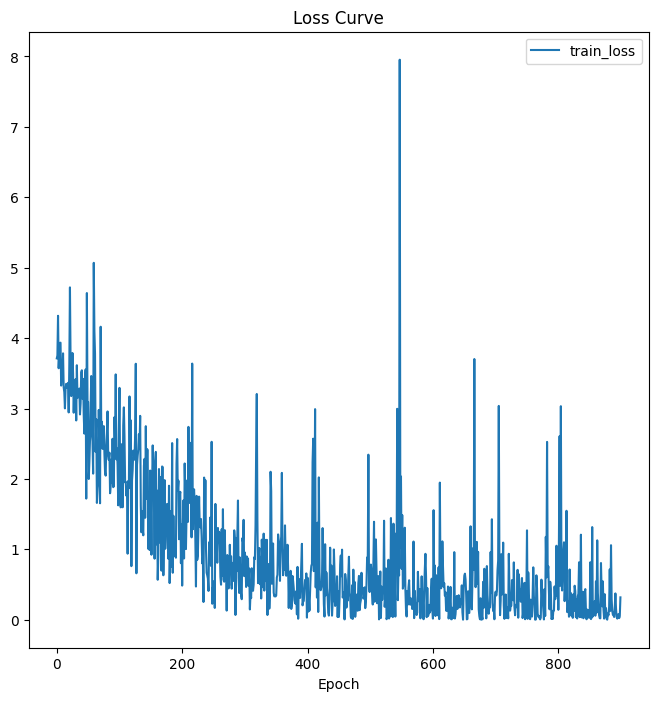

In [99]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,8))
plt.title("Loss Curve")
plt.plot(loss_logger, label='train_loss')
# plt.plot(accuracy_logger,label='accuracy')
plt.xlabel("Epoch")
plt.legend()
plt.show()

### Save and Load Model

In [100]:
pad_sequence(sequences, batch_first=True)

tensor([[[ 0.4849,  0.2484, -1.3873,  ...,  0.5543,  0.2162,  0.0108],
         [ 0.4846,  0.2500, -1.4881,  ...,  0.5539,  0.2157,  0.0111],
         [ 0.4844,  0.2507, -1.4935,  ...,  0.5537,  0.2161,  0.0111],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.5097,  0.2301, -1.2305,  ...,  0.5773,  0.2070,  0.0135],
         [ 0.5098,  0.2316, -1.4094,  ...,  0.5762,  0.2072,  0.0130],
         [ 0.5099,  0.2328, -1.4219,  ...,  0.5754,  0.2074,  0.0134],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.4868,  0.2821, -1.4668,  ...,  0.5711,  0.2335,  0.0116],
         [ 0.4861,  0.2786, -1.5812,  ...,  0

In [101]:
# Put the model in evaluation mode
model.eval()

# No need to track gradients during inference
with torch.no_grad():
    # Get the model's output (logits)
    outputs = model(padded_sequences.to(device))

# outputs = torch.softmax(outputs, dim=1)
# outputs = torch.max(outputs,1)

outputs


tensor([[ 17.8681,   2.9155,  -3.4087,  ...,  -1.2084,   8.3982,   3.0308],
        [ -2.9383,  23.6391,  -7.9109,  ...,  12.9623,  -7.1160, -17.9295],
        [ -8.5635,  -3.3380,  20.9489,  ...,  -8.9617,  -0.2316,  -4.1343],
        ...,
        [ -3.1277,   9.8875, -13.5798,  ...,  19.3296, -10.3671,  -6.7011],
        [  5.0350,  -0.9247,   6.1851,  ...,  -7.8592,  18.8588,   8.1509],
        [ -3.5002, -17.0256,  -0.2921,  ...,  -2.9302,   8.1149,  22.5467]],
       device='cuda:0')

In [102]:
padded_sequences

tensor([[[ 0.5013,  0.2452, -1.2167,  ...,  0.5663,  0.2188,  0.0098],
         [ 0.4997,  0.2482, -1.4690,  ...,  0.5652,  0.2181,  0.0106],
         [ 0.4984,  0.2500, -1.4853,  ...,  0.5654,  0.2185,  0.0112],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.4922,  0.2382, -1.2850,  ...,  0.5578,  0.2124,  0.0094],
         [ 0.4920,  0.2405, -1.4288,  ...,  0.5571,  0.2116,  0.0099],
         [ 0.4920,  0.2409, -1.4093,  ...,  0.5567,  0.2122,  0.0098],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.5049,  0.2371, -1.2115,  ...,  0.5643,  0.2082,  0.0088],
         [ 0.5045,  0.2381, -1.1896,  ...,  0

In [103]:
file_paths = ["Data for different actions/เขิน_0.mp4/เขิน_0.npy"]

In [104]:
# Load the sequences
import torch
sequences = load_keypoint_sequences(file_paths)
# Change list to numpy array 
sequences = np.array(sequences)
# Change numpy array to tensor
sequences = torch.FloatTensor(sequences)
sequences = pad_sequence(sequences, batch_first=True)
sequences

tensor([[[ 0.4321,  0.2240, -1.4261,  ...,  0.4724,  0.1833,  0.0108],
         [ 0.4325,  0.2250, -1.4727,  ...,  0.4722,  0.1847,  0.0102],
         [ 0.4330,  0.2258, -1.4930,  ...,  0.4725,  0.1845,  0.0109],
         ...,
         [ 0.4396,  0.2238, -1.5889,  ...,  0.4802,  0.1780,  0.0139],
         [ 0.4395,  0.2238, -1.5796,  ...,  0.4802,  0.1776,  0.0141],
         [ 0.4394,  0.2234, -1.5304,  ...,  0.4799,  0.1771,  0.0144]]])

In [105]:
outputs = model(sequences.to(device))
outputs

tensor([[  0.7628,   1.4544,  -9.3106,   4.4172,  -3.0898,  -0.8151,  -1.4743,
          -8.2852,  -9.7280,  -1.8283,  -4.4078,   2.1318,  12.8075,  -9.8904,
           1.8754,  -4.1046,  18.3557, -13.2573,  -9.9629,  13.2410,  13.5419,
          -4.1691,  -8.6830,  -9.7755,  11.7629,   4.6539,  -1.3114,   8.8859,
          -7.3469,   7.7218,   5.6856,  -4.7450, -15.1013,  -3.3907,  -7.2097,
          15.6571, -18.1863,   1.3903,  -9.2218,  -8.8252]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [106]:
labels = [action.split(".")[0] for action in actions]
labels

['กฎกระทรวง',
 'กฎหมายรัฐธรรมนูญ',
 'กรมอนามัย',
 'กรรม',
 'กรรมสิทธิ์',
 'กระโดด',
 'กล้วยบวชชี',
 'กล้วยเชื่อม',
 'กังวล',
 'กีฬา',
 'น้อง',
 'เขิน',
 'เขื่อนดิน',
 'เขื่อนสิริกิติ์',
 'เข้าใจผิด',
 'เคย',
 'เครียด',
 'เครื่องปั่นดิน',
 'เครื่องหมายการค้า',
 'เจอ',
 'เจ้าหนี้',
 'เช่าซื้อ',
 'เช่าทรัพย์',
 'เซอร์เบีย',
 'เซเนกัล',
 'เซ็ง',
 'เดิน',
 'เดิมพัน',
 'เพลีย',
 'เมื่อย',
 'เม็กซิโก',
 'เฮโรอีน',
 'แกมเบีย',
 'แซมเบีย',
 'โกหก',
 'โจทก์',
 'โชจู',
 'ใกล้',
 'ไดโนเสาร์',
 'ไอซ์']

In [107]:
# Change from tensor to numpy arrat
outputs = outputs.cpu().detach().numpy()

In [108]:
outputs

array([[  0.76275814,   1.4544413 ,  -9.310627  ,   4.417235  ,
         -3.0897903 ,  -0.8151227 ,  -1.474344  ,  -8.285211  ,
         -9.727998  ,  -1.8283273 ,  -4.4077754 ,   2.1318164 ,
         12.807451  ,  -9.89045   ,   1.8753879 ,  -4.1046114 ,
         18.35571   , -13.257321  ,  -9.962934  ,  13.240992  ,
         13.54185   ,  -4.1691318 ,  -8.682971  ,  -9.775506  ,
         11.762882  ,   4.6538744 ,  -1.3114276 ,   8.885937  ,
         -7.3469157 ,   7.721817  ,   5.685642  ,  -4.744951  ,
        -15.101321  ,  -3.3907366 ,  -7.209688  ,  15.657137  ,
        -18.186344  ,   1.3902954 ,  -9.221787  ,  -8.825155  ]],
      dtype=float32)

In [109]:
for idx, word in enumerate(outputs):
    # max_value = torch.max(outputs)
    list_outputs = max(outputs)
    print(list_outputs)
    # print(max_value)
    # print(max_value.detach().numpy())

[  0.76275814   1.4544413   -9.310627     4.417235    -3.0897903
  -0.8151227   -1.474344    -8.285211    -9.727998    -1.8283273
  -4.4077754    2.1318164   12.807451    -9.89045      1.8753879
  -4.1046114   18.35571    -13.257321    -9.962934    13.240992
  13.54185     -4.1691318   -8.682971    -9.775506    11.762882
   4.6538744   -1.3114276    8.885937    -7.3469157    7.721817
   5.685642    -4.744951   -15.101321    -3.3907366   -7.209688
  15.657137   -18.186344     1.3902954   -9.221787    -8.825155  ]


In [110]:
index_max = max(range(len(list_outputs)), key=list_outputs.__getitem__)
index_max

16

In [111]:
print(labels[index_max])

เครียด


In [112]:
correct = 0
num_clip = 0
for clip in labels:
    # print(clip)
    file_paths = [f"Data for different actions/{clip}.mp4/{clip}.npy"]
    # print(file_paths)

    sequences = load_keypoint_sequences(file_paths)
    # Change list to numpy array 
    sequences = np.array(sequences)
    # Change numpy array to tensor
    sequences = torch.FloatTensor(sequences)
    sequences = pad_sequence(sequences, batch_first=True)

    outputs = model(sequences.to(device))

    for idx, word in enumerate(outputs):
        # max_value = torch.max(outputs)
        list_outputs = max(outputs)

    index_max = max(range(len(list_outputs)), key=list_outputs.__getitem__)

    print(f"Input : {clip} Predicted : {labels[index_max]}")

    if clip == labels[index_max]:
        correct = correct+1
    
    num_clip = num_clip + 1 

print(f"Correct Predicted on Training set : {correct} Corrct percentage : {correct*100/num_clip}%")

Input : กฎกระทรวง Predicted : กฎกระทรวง
Input : กฎหมายรัฐธรรมนูญ Predicted : กฎหมายรัฐธรรมนูญ
Input : กรมอนามัย Predicted : กรมอนามัย
Input : กรรม Predicted : กรรม
Input : กรรมสิทธิ์ Predicted : กรรมสิทธิ์
Input : กระโดด Predicted : กระโดด
Input : กล้วยบวชชี Predicted : กล้วยบวชชี
Input : กล้วยเชื่อม Predicted : กล้วยเชื่อม
Input : กังวล Predicted : กังวล
Input : กีฬา Predicted : กีฬา
Input : น้อง Predicted : น้อง
Input : เขิน Predicted : เขิน
Input : เขื่อนดิน Predicted : เขื่อนดิน
Input : เขื่อนสิริกิติ์ Predicted : เขื่อนสิริกิติ์
Input : เข้าใจผิด Predicted : เข้าใจผิด
Input : เคย Predicted : เดิน
Input : เครียด Predicted : เขื่อนดิน
Input : เครื่องปั่นดิน Predicted : เครื่องปั่นดิน
Input : เครื่องหมายการค้า Predicted : เครื่องหมายการค้า
Input : เจอ Predicted : เขื่อนดิน
Input : เจ้าหนี้ Predicted : เจ้าหนี้
Input : เช่าซื้อ Predicted : เช่าซื้อ
Input : เช่าทรัพย์ Predicted : เช่าทรัพย์
Input : เซอร์เบีย Predicted : เซอร์เบีย
Input : เซเนกัล Predicted : โจทก์
Input : เซ็ง Predicted

In [113]:
print(labels)

['กฎกระทรวง', 'กฎหมายรัฐธรรมนูญ', 'กรมอนามัย', 'กรรม', 'กรรมสิทธิ์', 'กระโดด', 'กล้วยบวชชี', 'กล้วยเชื่อม', 'กังวล', 'กีฬา', 'น้อง', 'เขิน', 'เขื่อนดิน', 'เขื่อนสิริกิติ์', 'เข้าใจผิด', 'เคย', 'เครียด', 'เครื่องปั่นดิน', 'เครื่องหมายการค้า', 'เจอ', 'เจ้าหนี้', 'เช่าซื้อ', 'เช่าทรัพย์', 'เซอร์เบีย', 'เซเนกัล', 'เซ็ง', 'เดิน', 'เดิมพัน', 'เพลีย', 'เมื่อย', 'เม็กซิโก', 'เฮโรอีน', 'แกมเบีย', 'แซมเบีย', 'โกหก', 'โจทก์', 'โชจู', 'ใกล้', 'ไดโนเสาร์', 'ไอซ์']


In [114]:
import os 
video_dir = "C:/Users/araya/Desktop/augments"
video_list = []
video_list = os.listdir(video_dir)

len(video_list)

80

In [115]:
# Path for exported data, numpy arrays
Model_Data=os.path.join('../MediaPipe/Test')

actions_test = np.array(video_list)

no_of_seqs = 1

# 30 frames in length
seq_length = 160

In [116]:
labels_test = [action.split(".")[0] for action in actions_test]
labels_test

['กฎกระทรวง_0',
 'กฎกระทรวง_1',
 'กฎหมายรัฐธรรมนูญ_0',
 'กฎหมายรัฐธรรมนูญ_1',
 'กรมอนามัย_0',
 'กรมอนามัย_1',
 'กรรม_0',
 'กรรม_1',
 'กรรมสิทธิ์_0',
 'กรรมสิทธิ์_1',
 'กระโดด_0',
 'กระโดด_1',
 'กล้วยบวชชี_0',
 'กล้วยบวชชี_1',
 'กล้วยเชื่อม_0',
 'กล้วยเชื่อม_1',
 'กังวล_0',
 'กังวล_1',
 'กีฬา_0',
 'กีฬา_1',
 'น้อง_0',
 'น้อง_1',
 'เขิน_0',
 'เขิน_1',
 'เขื่อนดิน_0',
 'เขื่อนดิน_1',
 'เขื่อนสิริกิติ์_0',
 'เขื่อนสิริกิติ์_1',
 'เข้าใจผิด_0',
 'เข้าใจผิด_1',
 'เคย_0',
 'เคย_1',
 'เครียด_0',
 'เครียด_1',
 'เครื่องปั่นดิน_0',
 'เครื่องปั่นดิน_1',
 'เครื่องหมายการค้า_0',
 'เครื่องหมายการค้า_1',
 'เจอ_0',
 'เจอ_1',
 'เจ้าหนี้_0',
 'เจ้าหนี้_1',
 'เช่าซื้อ_0',
 'เช่าซื้อ_1',
 'เช่าทรัพย์_0',
 'เช่าทรัพย์_1',
 'เซอร์เบีย_0',
 'เซอร์เบีย_1',
 'เซเนกัล_0',
 'เซเนกัล_1',
 'เซ็ง_0',
 'เซ็ง_1',
 'เดิน_0',
 'เดิน_1',
 'เดิมพัน_0',
 'เดิมพัน_1',
 'เพลีย_0',
 'เพลีย_1',
 'เมื่อย_0',
 'เมื่อย_1',
 'เม็กซิโก_0',
 'เม็กซิโก_1',
 'เฮโรอีน_0',
 'เฮโรอีน_1',
 'แกมเบีย_0',
 'แกมเบีย_1',
 'แซมเบีย_0',
 'แซมเบี

In [117]:
file_paths = []
for action in actions_test:
    video_path = os.path.join('Test/', action)
    # print(video_path)
    # print(action)
    file_paths.append(video_path + '/' + action.split(".")[0] + ".npy")
print(file_paths)

['Test/กฎกระทรวง_0.mp4/กฎกระทรวง_0.npy', 'Test/กฎกระทรวง_1.mp4/กฎกระทรวง_1.npy', 'Test/กฎหมายรัฐธรรมนูญ_0.mp4/กฎหมายรัฐธรรมนูญ_0.npy', 'Test/กฎหมายรัฐธรรมนูญ_1.mp4/กฎหมายรัฐธรรมนูญ_1.npy', 'Test/กรมอนามัย_0.mp4/กรมอนามัย_0.npy', 'Test/กรมอนามัย_1.mp4/กรมอนามัย_1.npy', 'Test/กรรม_0.mp4/กรรม_0.npy', 'Test/กรรม_1.mp4/กรรม_1.npy', 'Test/กรรมสิทธิ์_0.mp4/กรรมสิทธิ์_0.npy', 'Test/กรรมสิทธิ์_1.mp4/กรรมสิทธิ์_1.npy', 'Test/กระโดด_0.mp4/กระโดด_0.npy', 'Test/กระโดด_1.mp4/กระโดด_1.npy', 'Test/กล้วยบวชชี_0.mp4/กล้วยบวชชี_0.npy', 'Test/กล้วยบวชชี_1.mp4/กล้วยบวชชี_1.npy', 'Test/กล้วยเชื่อม_0.mp4/กล้วยเชื่อม_0.npy', 'Test/กล้วยเชื่อม_1.mp4/กล้วยเชื่อม_1.npy', 'Test/กังวล_0.mp4/กังวล_0.npy', 'Test/กังวล_1.mp4/กังวล_1.npy', 'Test/กีฬา_0.mp4/กีฬา_0.npy', 'Test/กีฬา_1.mp4/กีฬา_1.npy', 'Test/น้อง_0.mp4/น้อง_0.npy', 'Test/น้อง_1.mp4/น้อง_1.npy', 'Test/เขิน_0.mp4/เขิน_0.npy', 'Test/เขิน_1.mp4/เขิน_1.npy', 'Test/เขื่อนดิน_0.mp4/เขื่อนดิน_0.npy', 'Test/เขื่อนดิน_1.mp4/เขื่อนดิน_1.npy', 'Test/เขื่อนสิริกิติ์_0

In [118]:
correct = 0
num_clip = 0
for clip in labels_test:
    # print(clip)
    file_paths = [f"Test/{clip}.mp4/{clip}.npy"]
    # print(file_paths)

    sequences = load_keypoint_sequences(file_paths)
    # Change list to numpy array 
    sequences = np.array(sequences)
    # Change numpy array to tensor
    sequences = torch.FloatTensor(sequences)
    sequences = pad_sequence(sequences, batch_first=True)

    outputs = model(sequences.to(device))

    for idx, word in enumerate(outputs):
        # max_value = torch.max(outputs)
        list_outputs = max(outputs)

    index_max = max(range(len(list_outputs)), key=list_outputs.__getitem__)

    print(f"Input : {clip} Predicted : {labels[index_max]}")

    if clip == labels[index_max]:
        correct = correct+1
    
    num_clip = num_clip + 1 

print(f"Correct Predicted on Training set : {correct} Corrct percentage : {correct*100/num_clip}%")

Input : กฎกระทรวง_0 Predicted : เฮโรอีน
Input : กฎกระทรวง_1 Predicted : กฎกระทรวง
Input : กฎหมายรัฐธรรมนูญ_0 Predicted : แซมเบีย
Input : กฎหมายรัฐธรรมนูญ_1 Predicted : กฎหมายรัฐธรรมนูญ
Input : กรมอนามัย_0 Predicted : เช่าซื้อ
Input : กรมอนามัย_1 Predicted : กรมอนามัย
Input : กรรม_0 Predicted : เซอร์เบีย
Input : กรรม_1 Predicted : เข้าใจผิด
Input : กรรมสิทธิ์_0 Predicted : กฎกระทรวง
Input : กรรมสิทธิ์_1 Predicted : แกมเบีย
Input : กระโดด_0 Predicted : เครียด
Input : กระโดด_1 Predicted : กระโดด
Input : กล้วยบวชชี_0 Predicted : น้อง
Input : กล้วยบวชชี_1 Predicted : กีฬา
Input : กล้วยเชื่อม_0 Predicted : กฎหมายรัฐธรรมนูญ
Input : กล้วยเชื่อม_1 Predicted : กฎหมายรัฐธรรมนูญ
Input : กังวล_0 Predicted : กฎกระทรวง
Input : กังวล_1 Predicted : โชจู
Input : กีฬา_0 Predicted : เครื่องหมายการค้า
Input : กีฬา_1 Predicted : เครื่องหมายการค้า
Input : น้อง_0 Predicted : กีฬา
Input : น้อง_1 Predicted : น้อง
Input : เขิน_0 Predicted : เครียด
Input : เขิน_1 Predicted : เขิน
Input : เขื่อนดิน_0 Predicted : แ

### -------------------------------------------------------------------------------------------------------------------------------------------- ###

In [498]:
import pandas as pd

In [ ]:
video_list

In [500]:
columns = ["word"]

In [ ]:
pd.DataFrame(video_list, columns=columns)

ชื่อไฟลล์ที่รวม Augment มาด้วย

In [502]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir("Data for different actions")]

In [ ]:
onlyfiles

In [ ]:
df = pd.DataFrame(onlyfiles, columns=columns)
df

In [505]:
df.to_csv('script.csv', index=False)

### Read File

In [ ]:
y = pd.read_csv("script.csv")
y

In [ ]:
y["label"] = y["label"].astype(int)
labels = y.label
labels